## Define key variables and functions

### Define JPEG standard quantization table

In [1]:
import numpy as np

q_table_luminance = np.array([
    [16,  11,  10,  16,  24,  40,  51,  61],
    [12,  12,  14,  19,  26,  58,  60,  55],
    [14,  13,  16,  24,  40,  57,  69,  56],
    [14,  17,  22,  29,  51,  87,  80,  62],
    [18,  22,  37,  56,  68, 109, 103,  77],
    [24,  35,  55,  64,  81, 104, 113,  92],
    [49,  64,  78,  87, 103, 121, 120, 101],
    [72,  92,  95,  98, 112, 100, 103,  99]
])

q_table_chrominance = np.array([
    [17,  18,  24,  47,  99,  99,  99,  99],
    [18,  21,  26,  66,  99,  99,  99,  99],
    [24,  26,  56,  99,  99,  99,  99,  99],
    [47,  66,  99,  99,  99,  99,  99,  99],
    [99,  99,  99,  99,  99,  99,  99,  99],
    [99,  99,  99,  99,  99,  99,  99,  99],
    [99,  99,  99,  99,  99,  99,  99,  99],
    [99,  99,  99,  99,  99,  99,  99,  99]
])

def scale_q_table(q_table, q_factor):
    if q_factor <= 0:
        q_factor = 1
    if q_factor > 100:
        q_factor = 100

    if q_factor < 50:
        scale_factor = 5000 / q_factor
    else:
        scale_factor = 200 - q_factor * 2
    
    scaled_table = (q_table * scale_factor + 50) // 100
    scaled_table[scaled_table <= 0] = 1  # prevent zero division
    return scaled_table

In [2]:
scale_q_table(q_table_luminance, 75)

array([[ 8,  6,  5,  8, 12, 20, 26, 31],
       [ 6,  6,  7, 10, 13, 29, 30, 28],
       [ 7,  7,  8, 12, 20, 29, 35, 28],
       [ 7,  9, 11, 15, 26, 44, 40, 31],
       [ 9, 11, 19, 28, 34, 55, 52, 39],
       [12, 18, 28, 32, 41, 52, 57, 46],
       [25, 32, 39, 44, 52, 61, 60, 51],
       [36, 46, 48, 49, 56, 50, 52, 50]])

### Zig-zag scan algorithm

In [3]:
# ref: https://github.com/getsanjeev/compression-DCT/blob/master/zigzag.py

# Zigzag scan of a matrix
# Argument is a two-dimensional matrix of any size,
# not strictly a square one.
# Function returns a 1-by-(m*n) array,
# where m and n are sizes of an input matrix,
# consisting of its items scanned by a zigzag method.

def zigzag(input):
    #initializing the variables
    #----------------------------------
    h = 0
    v = 0

    vmin = 0
    hmin = 0

    vmax = input.shape[0]
    hmax = input.shape[1]
    
    i = 0

    output = np.zeros(( vmax * hmax), dtype=int)
    #----------------------------------

    while ((v < vmax) and (h < hmax)):
        
        if ((h + v) % 2) == 0:                 # going up
            
            if (v == vmin):
                output[i] = input[v, h]        # if we got to the first line

                if (h == hmax):
                    v = v + 1
                else:
                    h = h + 1                        

                i = i + 1

            elif ((h == hmax -1 ) and (v < vmax)):   # if we got to the last column
                output[i] = input[v, h] 
                v = v + 1
                i = i + 1

            elif ((v > vmin) and (h < hmax -1 )):    # all other cases
                #print(3)
                output[i] = input[v, h] 
                v = v - 1
                h = h + 1
                i = i + 1
        
        else:                                    # going down

            if ((v == vmax -1) and (h <= hmax -1)):       # if we got to the last line
                output[i] = input[v, h] 
                h = h + 1
                i = i + 1
        
            elif (h == hmin):                  # if we got to the first column
                output[i] = input[v, h] 

                if (v == vmax -1):
                    h = h + 1
                else:
                    v = v + 1

                i = i + 1

            elif ((v < vmax -1) and (h > hmin)):     # all other cases
                output[i] = input[v, h] 
                v = v + 1
                h = h - 1
                i = i + 1

        if ((v == vmax-1) and (h == hmax-1)):          # bottom right element
            output[i] = input[v, h] 
            break

    return output

# Inverse zigzag scan of a matrix
# Arguments are: a 1-by-m*n array, 
# where m & n are vertical & horizontal sizes of an output matrix.
# Function returns a two-dimensional matrix of defined sizes,
# consisting of input array items gathered by a zigzag method.

def inverse_zigzag(input, vmax, hmax):
    # initializing the variables
    #----------------------------------
    h = 0
    v = 0

    vmin = 0
    hmin = 0

    output = np.zeros((vmax, hmax), dtype=int)

    i = 0
    #----------------------------------

    while ((v < vmax) and (h < hmax)): 
        if ((h + v) % 2) == 0:                 # going up
            
            if (v == vmin):                
                output[v, h] = input[i]        # if we got to the first line

                if (h == hmax):
                    v = v + 1
                else:
                    h = h + 1                        

                i = i + 1

            elif ((h == hmax -1 ) and (v < vmax)):   # if we got to the last column
                output[v, h] = input[i] 
                v = v + 1
                i = i + 1

            elif ((v > vmin) and (h < hmax -1 )):    # all other cases
                output[v, h] = input[i] 
                v = v - 1
                h = h + 1
                i = i + 1
                
        else:                                    # going down

            if ((v == vmax -1) and (h <= hmax -1)):       # if we got to the last line
                output[v, h] = input[i] 
                h = h + 1
                i = i + 1
        
            elif (h == hmin):                  # if we got to the first column
                output[v, h] = input[i] 
                if (v == vmax -1):
                    h = h + 1
                else:
                    v = v + 1
                i = i + 1
                                
            elif((v < vmax -1) and (h > hmin)):     # all other cases
                output[v, h] = input[i] 
                v = v + 1
                h = h - 1
                i = i + 1

        if ((v == vmax-1) and (h == hmax-1)):          # bottom right element
            output[v, h] = input[i] 
            break

    return output

In [4]:
col_idx, row_idx = np.meshgrid(np.arange(8),np.arange(8))
zigzag_row_idx = zigzag(row_idx)
zigzag_col_idx = zigzag(col_idx)

In [5]:
a = np.random.randint(10, size=(8,8))
dct_n = 21
print(a)
print(f"First {dct_n} coefficients in zig-zag order:\n", a[zigzag_row_idx[:dct_n], zigzag_col_idx[:dct_n]])

[[5 1 5 2 4 0 4 8]
 [2 5 9 5 0 8 7 2]
 [3 5 3 2 5 4 8 2]
 [9 2 3 0 9 9 6 1]
 [8 3 7 7 9 8 2 0]
 [3 3 9 1 9 4 4 0]
 [4 2 0 3 4 4 0 9]
 [0 2 5 1 1 9 1 0]]
First 21 coefficients in zig-zag order:
 [5 1 2 3 5 5 2 9 5 9 8 2 3 5 4 0 0 2 3 3 3]


## JPEG q-table estimation algorithm

### Testing JPEG compression with `PIL`

Use a RAW tiff image taken from the RAISE dataset, jpeg compress the image using a quantization table I know.

In [6]:
import numpy as np
from PIL import Image
import jpeglib

Convert to grayscale to remove potential confusions with the chrominance quantization tables

In [7]:
im = Image.open('raise_1k/r146771d7t.TIF').convert('L')

Take a random custom table

In [ ]:
my_q_table = custom_q_tables['q_table'][1000][0]
my_q_table

`PIL` accepts q tables as a list of 64 integers, which are **NOT** in zigzag fashion, but in **normal array order**. [[ref](https://github.com/libjpeg-turbo/libjpeg-turbo/blob/main/libjpeg.txt#L937)]

In [6]:
my_q_table = my_q_table.reshape(-1)
my_q_table

array([ 3,  2, 10, 10, 10,  8,  8,  8,  2, 10, 10, 10,  8,  8,  8,  8, 10,
       10, 10, 10,  8,  8,  8,  8, 10, 10,  8,  8,  8,  8,  8,  8, 10,  8,
        8,  8,  8, 10,  9,  8,  8,  8,  8,  8,  8, 10, 13,  8,  8,  8,  8,
        8,  9, 13, 12,  8,  8,  8,  8,  8, 10,  8,  9,  8], dtype=uint8)

In [7]:
im.save('test_pil.jpg', qtables=[my_q_table], subsampling=0)

Read with `PIL` and check

In [8]:
check_pil = Image.open('test_pil.jpg')
check_pil.quantization[0] - my_q_table

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Read with `jpeglib` and check

In [9]:
check_jlib = jpeglib.read_dct("test_pil.jpg")
check_jlib.qt - my_q_table.reshape((8,8))

array([[[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]]], dtype=int16)

Check with `torchjpeg`

In [10]:
import torchjpeg.codec
dimensions, quantization, Y_coefficients, CbCr_coefficients = torchjpeg.codec.read_coefficients("test_pil.jpg")

In [11]:
quantization - my_q_table.reshape((8,8))

tensor([[[0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0]]], dtype=torch.int16)

### Test out `crop_leave4`

In [63]:
def crop_leave4(im):
    return im.crop((4, 4, im.size[0]-4, im.size[1]-4))

In [64]:
bw_im = np.ones((12,16), dtype=np.uint8) * 126
bw_im[4:8,4:12] = 0
print(bw_im.shape)
print(bw_im)
Image.fromarray(bw_im).show()

(12, 16)
[[126 126 126 126 126 126 126 126 126 126 126 126 126 126 126 126]
 [126 126 126 126 126 126 126 126 126 126 126 126 126 126 126 126]
 [126 126 126 126 126 126 126 126 126 126 126 126 126 126 126 126]
 [126 126 126 126 126 126 126 126 126 126 126 126 126 126 126 126]
 [126 126 126 126   0   0   0   0   0   0   0   0 126 126 126 126]
 [126 126 126 126   0   0   0   0   0   0   0   0 126 126 126 126]
 [126 126 126 126   0   0   0   0   0   0   0   0 126 126 126 126]
 [126 126 126 126   0   0   0   0   0   0   0   0 126 126 126 126]
 [126 126 126 126 126 126 126 126 126 126 126 126 126 126 126 126]
 [126 126 126 126 126 126 126 126 126 126 126 126 126 126 126 126]
 [126 126 126 126 126 126 126 126 126 126 126 126 126 126 126 126]
 [126 126 126 126 126 126 126 126 126 126 126 126 126 126 126 126]]


In [65]:
cropped_bw_im = crop_leave4(Image.fromarray(bw_im))
print(np.array(cropped_bw_im).shape)
print(np.array(cropped_bw_im))
cropped_bw_im.show()

(4, 8)
[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


### Test out `get_closest_histogram`

[Reference for $\chi^2$ histogram distance](https://stats.stackexchange.com/questions/184101/comparing-two-histograms-using-chi-square-distance)

In [77]:
def chi2_hist_distance(h1, h2):
    distance = 0
    for b in range(len(h1)):
        if h1[b] == 0 and h2[b] == 0:
            continue
        distance += (h1[b] - h2[b])**2 / (h1[b] + h2[b])
 
    return distance

In [82]:
cmp = np.random.randint(h.min(), high=h.max(), size=h.shape)
print(chi2_hist_distance(h, cmp))
print(chi2_hist_distance(cmp, h))

1483.0565804315095
1483.0565804315095


In [98]:
def get_closest_histogram(reference, histogram_list):
    smallest_dist = np.inf
    smallest_idx = -1
    closest_hist = None
    
    for idx, h in enumerate(histogram_list):
        dist = chi2_hist_distance(h, reference)
        
        if dist < smallest_dist:
            smallest_dist = dist
            smallest_idx = idx
            closest_hist = h
    
    return closest_hist, smallest_idx

In [99]:
h[0]

4

In [100]:
cmp2 = np.array(h)
cmp2[0] = 0
print(chi2_hist_distance(h, cmp2))

4.0


In [103]:
closest_h, idx = get_closest_histogram(h, [cmp, cmp2])
print(idx)
print(closest_h - cmp2)

1
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Test out writing and saving image to memory instead of disk

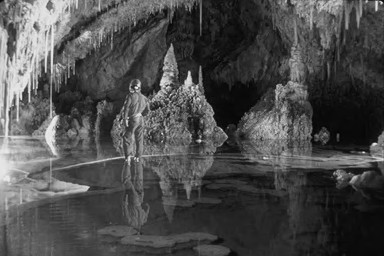

In [259]:
import io

im = Image.open('test.jpg').convert('L')
im.show()

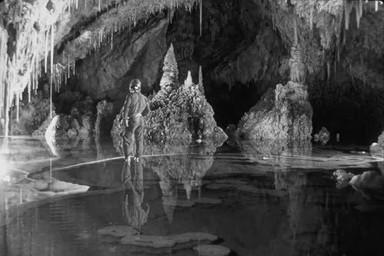

In [260]:
buf = io.BytesIO()
im.save(buf, format='JPEG')
im_grey = Image.open(buf)
im_grey.show()

### Final estimation algorithm

In [6]:
import io
import jpeglib
from PIL import Image

def crop_leave4(im):
    return im.crop((4, 4, im.size[0]-4, im.size[1]-4))

def jpeg_custom_compress(im, q_table):
    """
    Compresses a PIL image `im` using quantization table `q_table` and saves the result
    in memory to a buffer.
    Args:
        im: PIL image.
        q_table: A list of 64 integers in normal array order, not zigzag fashion.
    Returns:
        The buffer where the image is saved
    """    
    # This compression step quantizes the image
    buffer = io.BytesIO()
    im.save(buffer, format='jpeg', qtables=[q_table], subsampling=0) # no chroma-subsampling
    return buffer

def chi2_hist_distance(h1, h2):
    distance = 0
    for b in range(len(h1)):
        if h1[b] == 0 and h2[b] == 0:
            continue
        distance += (h1[b] - h2[b])**2 / (h1[b] + h2[b])
 
    return distance

def get_closest_histogram(reference, histogram_list):
    smallest_dist = np.inf
    smallest_idx = -1
    closest_hist = None
    
    for idx, h in enumerate(histogram_list):
        dist = chi2_hist_distance(h, reference)
        
        if dist < smallest_dist:
            smallest_dist = dist
            smallest_idx = idx
            closest_hist = h
    
    return closest_hist, smallest_idx

def compute_dct_coefficient_histogram(im_path, bin_range=50):
    im = jpeglib.read_dct(im_path)
    q_table = im.qt[0]  # read the luminance quantization table
    dct_coef = im.Y.reshape(-1, 8, 8).transpose(0, 2, 1) * q_table[None,:]  # tranpose because jpeglib reads wrongly
    k_factor_list = dct_coef.reshape(-1, 64).transpose()
        
    histograms = []
    bins = []
    for k in range(len(k_factor_list)):
        # bin_range+2 since right most is excluded, ref: https://stackoverflow.com/questions/9141732/how-does-numpy-histogram-work
        h, b = np.histogram(k_factor_list[k], bins=np.arange(-bin_range,bin_range+2))
        histograms.append(h)
        bins.append(b)

    return np.array(histograms), np.array(bins)

def estimate_q_table(im_path, n, bin_range):
    """
    Args:
        im_path: Path to m-compressed image. Assume image is grayscale only.
        n: Greatest value assumed by quantization factors
    """
    # Step 1: Compute reference k DCT histograms for m-compressed image
    k_hists_ref, _ = compute_dct_coefficient_histogram(im_path, bin_range=bin_range)
    
    # Step 2: Extract mth q-table of image
    im = Image.open(im_path)
    mth_q_table_lumi = im.quantization[0]  # already in flattened 64 integers
    
    # Step 3: Crop out a patch, leaving 4 pixels on each side to break JPEG block alignment
    patch = crop_leave4(im)
    
    # Step 4: Create n constant matrices and do compression
    k_hists_compare = []
    for i in range(1, n+1):
        # Create constant matrix with element i
        # M_i is just a length 64 constant array since jpeg compress takes in a 1d array
        M_i = np.full((64), i)
        
        # Compress patch using M_i
        C_p_buffer = jpeg_custom_compress(patch, M_i)
        
        # Compress again using mth_q_table
        C_p = Image.open(C_p_buffer)
        C_pp_buffer = jpeg_custom_compress(C_p, mth_q_table_lumi)
        
        with open("C_pp.jpg", "wb") as f:
            f.write(C_pp_buffer.getbuffer())
        
        # Read DCT coefficients of doubly compressed patch and compute histograms
        k_hists, _ = compute_dct_coefficient_histogram('C_pp.jpg', bin_range=bin_range)
        k_hists_compare.append(k_hists)
    
    k_hists_compare = np.array(k_hists_compare).transpose(1,0,2)
#     print(k_hists_compare.shape)
    
    # Step 5: Compute closest histogram using chi-square histogram distance
    estimation = np.zeros(64)
    for i in range(64):
        hist, idx = get_closest_histogram(k_hists_ref[i], k_hists_compare[i])
        best_n = idx + 1  # since n starts from 1
        estimation[i] = best_n
    
    return estimation.reshape((8,8))

### Test individual images

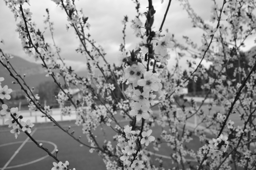

In [7]:
im_path = 'img_qf_70_90_1.jpg'
im = Image.open(im_path)
im.thumbnail((256,256))
im

In [9]:
import time

stime = time.time()
est = estimate_q_table(im_path, 73, 100)
print(f"Took {time.time() - stime} seconds.")
est

Took 65.01344227790833 seconds.


array([[10.,  7.,  6., 10., 14., 24., 29., 67.],
       [ 7.,  7.,  8., 11., 16., 35., 32., 38.],
       [ 8.,  8., 10., 14., 24., 33., 36., 37.],
       [ 8., 10., 13., 17., 28., 70., 32., 48.],
       [11., 13., 21., 29., 37., 45.,  1., 29.],
       [15., 21., 32., 52., 45., 34.,  5., 40.],
       [27., 34., 41., 34.,  1., 10., 10., 29.],
       [58., 54., 50., 51., 10., 35.,  9.,  9.]])

In [10]:
scale_q_table(q_table_luminance, 70)

array([[10,  7,  6, 10, 14, 24, 31, 37],
       [ 7,  7,  8, 11, 16, 35, 36, 33],
       [ 8,  8, 10, 14, 24, 34, 41, 34],
       [ 8, 10, 13, 17, 31, 52, 48, 37],
       [11, 13, 22, 34, 41, 65, 62, 46],
       [14, 21, 33, 38, 49, 62, 68, 55],
       [29, 38, 47, 52, 62, 73, 72, 61],
       [43, 55, 57, 59, 67, 60, 62, 59]])

In [12]:
def zigzag_diff_first_n(q1, q2, n):
    return q1[zigzag_row_idx[:n], zigzag_col_idx[:n]] - q2[zigzag_row_idx[:n], zigzag_col_idx[:n]]

zigzag_diff_first_n(est, scale_q_table(q_table_luminance, 70), 15)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])